# 3. 분류

## 3.1. MNIST
MNIST : 70,000개의 작은 숫자 이미지 데이터셋. 학습용으로 많이 쓰임.

In [10]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [11]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런 데이터셋 딕셔너리 구조
* 데이터셋을 설명하는 DESCR 키
* 샘플이 행, 특성이 열로 구성된 배열을 가진 data 키
* 레이블 배열을 담은 target 키


In [12]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

이미지가 28 * 28개의 픽셀로 이루어져있고, 각 특성은 0 ~ 255까지의 픽셀 강도(색)을 나타낸다.

In [13]:
y.shape

(70000,)

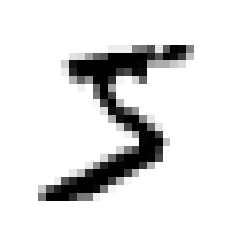

In [14]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [15]:
y[0]

'5'

In [16]:
y=y.astype(np.uint8)

train set, test set 나누기

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] # 훈련세트 이미 섞여있음.

## 3.2 이진 분류기 훈련
단순화시켜 5를 구분하는 이진 분류기(binary classifier)만들기

* 타깃 벡터 형성

In [18]:
y_train_5 = (y_train==5) # 5는 True, 다른 숫자는 모두 False
y_test_5 = (y_test==5) 

* SGD(확률적 경사 하강법/Stochastic Gradient Descent) 모델 선택    

    * 매운 큰 데이터를 효율적으로 처리하는 장점
    * 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기때문에 온란인 학습에 잘 들어맞음
    * sklearn의 SGDClassifier로 모델링 가능

In [19]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [20]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 성능 측정
### 3.3.1 교차 검증을 사용한 정확도 측정

* sklearn의 cross_val_score()

In [21]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

* 모델링 구현

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


* 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기

In [23]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [24]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

모든 이미지를 5 아님 클래스로 분류하는 분류기를  만들었는데 정확도로 성능을 측정했을 때 90% 이상이 나옴.  
-> 이미지의 10% 정도만 5였기 때문에 정확도가 높게 나왔다. 

-> 불균형한 데이터셋을 다룰 때 정확도를 분류기의 성능 측정 지표로 사용하는 것은 적합하지 않다.

### 3.3.2 오차행렬

* 오차행렬  
오차행렬(confusion matrix)는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것이다.  
실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 한다.

In [25]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf,  X_train, y_train_5, cv=3)
# cross_val_predict()는 kfold cross validation을 수행하지만 평가 점수를 반환(cross_val_score)하지 않고 각 테스트 폴드에서 얻은 예측을 반환

In [26]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

1행 : negative class (실제 5 아님 이미지)  
2행 : positive class (실제 5 이미지)  
1열 : 5 아니라고 예측  
2열 : 5 라고 예측  

1행 1열 : true negative (5 아님으로 정확히 분류)  
1행 2열 : false positive (5라고 잘못 분류)  
2행 1열 : false negative (5 아님으로 잘못 분류)  
2행 2열 : true positive (5라고 정확히 분류)  

완벽한 분류기의 경우 오차 행렬의 주대각선만 0이 아닌 값이 될 것.(대각행렬)

In [27]:
# 완벽한 분류기의 경우

y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

* 정밀도(precision)  
양성 예측의 정확도  
정밀도 = TP/(TP + FP)  

* 재현율(recall)  
분류기가 정확하게 감지한 양성 샘플의 비율   
민감도 또는 TPR(진짜 양성 비율)이라고도 한다.  
재현율 = TP/(TP + FN)

### 3.3.3 정밀도와 재현율

In [28]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # 5로 판별된 이미지중 83.7%만 정확

0.8370879772350012

In [29]:
recall_score(y_train_5, y_train_pred) # 전체 5중 65%만 감지

0.6511713705958311

* F1 score  
정밀도와 재현율의 조화 평균
F1 = 2/(1/정밀도 + 1/재현율) = 2*(정밀도*재현율)/(정밀도+재현율) = TP/(TP + (FN + FP)/2)

In [30]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

* 정밀도/재현율 트레이드오프  
정밀도를 올리면 재현율이 줄고, 재현율을 올리면 정밀도가 줄어든다.

### 3.3.4 정밀도/재현율 트레이드오프

SGDClassifier가 분류를 어떻게 결정하는지 살펴보며 트레이드오프를 이해  

SGDClassifier는 결정함수를 사용하여 각 샘플의 점수를 계산한다. 이 점수가 결정 임곗값(decision threshold)보다 크면 양성 클래스에, 작으면 음성 클래스에 샘플을 할당한다.  
결정 임곗값을 높이면 정밀도는 높아지고 재현율은 줄어든다. 반대로 임곗값은 낮추면 정밀도는 낮아지고 재현율은 높아진다.


In [31]:
y_scores =sgd_clf.decision_function([some_digit]) # decision_function : 각 샘플의 점수를 알 수 있음.
y_scores

array([2164.22030239])

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [33]:
y_some_digit_pred

array([ True])

In [34]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

적절한 threshold 정하는 방법

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [36]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

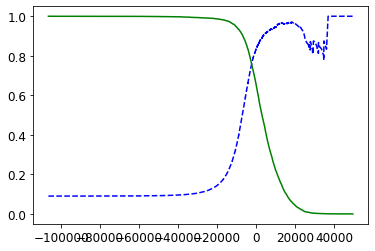

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label = "재현율")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [38]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # np.argmax : 최댓값의 첫 인덱스를 반환. 여기서는 () 조건이 처음으로 True가 되는 인덱스 반환

In [39]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [40]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [41]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

일정 정밀도를 달성하는 분류기를 만들 때, 재현율이 너무 낮진 않은지 확인해야 한다.

### 3.3.5 ROC 곡선

수신기 조작 특성(ROC)곡선도 이진 분류에서 널리 사용하는 도구이다.  
ROC곡선은 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR, 재현율)의 곡선이다.  
FPR은 양성으로 잘못 분류된 음성 샘플의 비율.  
FPR = 1-TNR(특이도(specificity), 음성으로 정확히 분류된 음성 샘플의 비율)  

ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프.

In [42]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

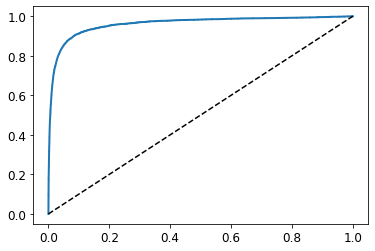

In [43]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어난다.  
좋은 분류기는 점선에서 최대한 멀리 떨어져있어야 한다.  
완벽한 분류기는 곡선 아래의 면적(AUG)가 1이고, 완전한 랜덤 분류기는 0.5 이다.  
AUG가 1에 가까울수록 좋은 분류기이다.

In [44]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

* ROC 곡선과 PR곡선 선택 tip  
- PR곡선 : 양성 클래스보다 음성 클래스가 압도적으로 많을때, FN 보다 FP가 더 중요할 때 사용  
- ROC 곡선 : 이 외의 경우에 사용  
- 이유 : 음성 클래스가 많아지게 되면 FP가 커져 정상적으로 양성 샘플을 분류할 수 없게 되어 높은 정밀도를 얻을 수 없게 됨.  
반면 ROC 곡선의 경우 음성 샘플의 수에 큰 영향을 받지 않아 양호한 결과를 보일 수 있다.

[참고] https://nanunzoey.tistory.com/entry/ROC-%EA%B3%A1%EC%84%A0-vs-P-R-%EA%B3%A1%EC%84%A0

* Random Forest Classifier 모델 선택

In [45]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [46]:
y_scores_forest = y_probas_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용(decision function 대신 predict_proba 써서)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

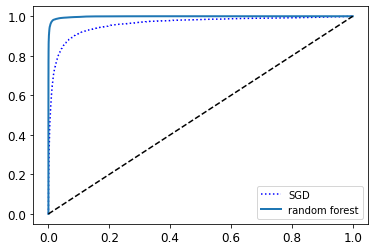

In [47]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "random forest")
plt.legend(loc="lower right")
plt.show()

sgd 보다 랜덤 포레스트 모델의 ROC 곡선의 AUG 점수가 휠씬 높다.

In [48]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [49]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [50]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## 3.4 다중 분류

다중분류기(multiclass classifier)는 둘 이상의 클래스를 구별할 수 있다.  

* 다중분류가 가능한 모델 : SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기
* 이진 분류만 가능한 모델 : 로지스틱 회귀, 서포트 벡터 머신 분류기 등
    * 이진 분류기를 여러 개 사용해 다중 클ㄹ래스를 분류하는 기법
        1. OvR(one versus the rest) 또는 OvA(one versus all)  
        ex) 특정 숫자 하나를 구별하는 이진 분류기를 10개 생성하면 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있다.  
        각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하면 된다.  
        대부분의 이진 분류 알고리즘에서 선호
        
        2. OvO(one versus one)  
        ex) 0과1, 1과 2 등 각 숫자 조합마다 이진 분류기를 훈련.  
        클래스가 N개이면 NC2개의 클래스 필요(N개중 2개를 뽑는.)  이미지 분류시 NC2개의 분류기 모두 통과시켜 가장 많이 양성으로 분류된 클래스를 선택.  
        장점은 구별할 두 클래스에 해당하는 샘플만 필요하다는 점으로 훈련 세트의 크기에 민감한 분류기에서 선호됨.

        다중클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 자동으로 OvR 또는 OvO를 실행한다.

* 서포트 벡터 머신 분류기

In [52]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [53]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores # 가장 높은 점수가 클래스 5에 해당하는 값임.

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [54]:
np.argmax(some_digit_scores)

5

In [55]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [56]:
svm_clf.classes_[5]

5

In [58]:
# 사이킷런에서 OvO, OvR 강제로 지정하는 경우
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [59]:
# 자동으로 다중 클래스로 분류하는 경우(sgd classifier나 randomforest 등등)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [60]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [61]:
# sgd분류기 평가_교차검증
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [62]:
# standardscale로 입력 스케일 조정하여 점수 향상
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석
가능성이 높은 모델을 찾았다고 가정하고 모델 성능 향상시킬 방법 중 하나는 에러의 종류를 분석하는 것이다.

In [63]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

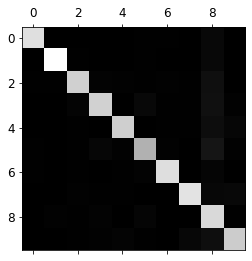

In [64]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [65]:
# 오차행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 "비율"을 비교
row_sums = conf_mx.sum(axis=1, keepdims=True) # keepdims는 True일때 dimension 유지
norm_conf_mx = conf_mx / row_sums

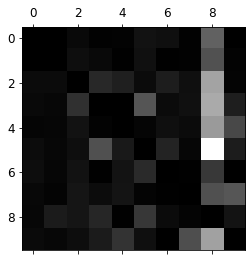

In [66]:
np.fill_diagonal(norm_conf_mx, 0) # 주대각선을 0으로 채우기
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

행은 실제 클래스, 열은 예측한 클래스를 나타내는데, 클래스8 열이 밝게 나오므로 많은 이미지가 8로 잘못 분류됨을 알 수 있음.  
* 해결책  
    * 8처럼 보이는 숫자의 훈련 데이터를 많이 모아서 실제 8과 구분하도록 분류기를 학습시킬 수 있다.
    * 분류기에 도움이 될 만한 특성을 찾는다.
    * 어떤 패턴이 드러나도록 이미지 전처리를 거친다.

* 3과 5의 샘플 살펴보기

In [67]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장: error_analysis_digits_plot


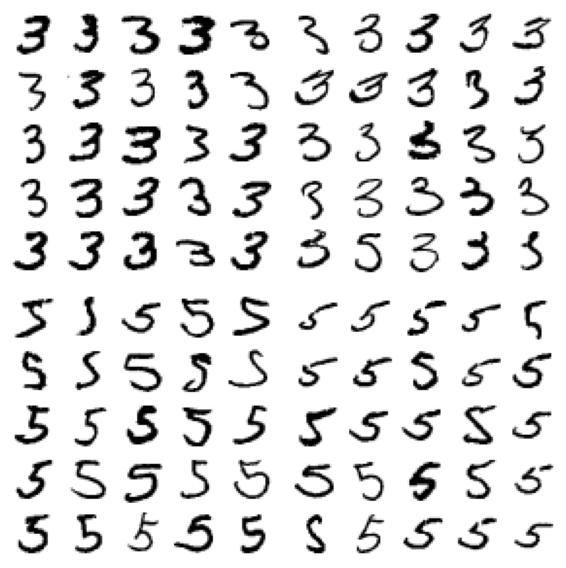

In [68]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5) # 실제 3을 3으로 예측
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5) # 실제 3을 5로 예측
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5) # 실제 5를 3으로 예측
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5) # 실제 5를 5로 예측
save_fig("error_analysis_digits_plot")
plt.show()

* 2, 3번째 블록에서 분류기가 실수한 이유  
선형 모델인 SGDClassifier를 사용했기 때문이다.  
선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산한다.  
따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 쉽게 혼동된다.

* 3과 5는 위 선과 아래 호를 이어주는 작은 선의 위치가 주요 차이인데, 이미지의 위치나 회전방향에 매우 민감하다.  
* 에러를 줄이는 한 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리 시키는 것이다.

## 3.6 다중 레이블 분류
분류기가 샘플마다 여러 개의 클래스를 출력해야 할 때도 있다.  
예로 엘리스와 찰리가 있는 사진을 본다면 엘리스와 찰리 클래스를 출력해야한다.  
이처럼 여러 개의 이진 꼬리표를 출력하는 분류 시스템을 다중 레이블 분류 시스템이라고 한다.

In [69]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] # 배열을 column으로 하여 옆에 붙이기

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [70]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [72]:
# 모든 레이블의 가중치가 같다고 가정한 경우 분류기 평가
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [73]:
# 앨리스 사진이 더 많아 가중치가 필요할 때
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

## 3.7 다중 출력 분류

다중 출력 분류는 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것이다.  
다중 레이블 분류는 샘플이 여러 클래스에 할당되는데, 이 클래스들은 이진 분류 클래스들인 반면,  
다중 출력 분류는 샘플이 여러 클래스에 할당되면서 각 클래스(레이블)들은 이진이 아닌 여러 값을 가진다.

* 이미지에서 잡음을 제거하는 시스템  
잡음이 많은 이미지를 입력받고 픽셀의 강도를 담은 배열로 이미지를 출력하면 픽셀당 한 레이블로 하여 샘플이 여러 레이블에 할당되고, 레이블은 0 ~ 255까지의 여러 값을 가지는 다중 출력 분류 시스템이다.

In [74]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

그림 저장: noisy_digit_example_plot


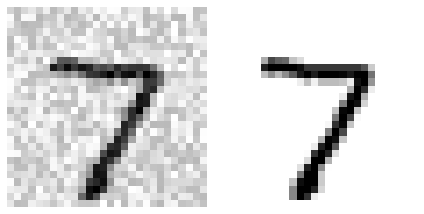

In [77]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

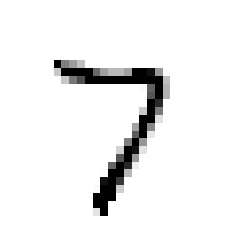

In [78]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)